In [108]:
#!pip install yfinance
#!pip install pandas-ta

In [109]:
import requests
import bs4 as bs
import pickle

import datetime as dt
import os

import pandas as pd
import pandas_datareader.data as pdr
import pandas_ta as ta

import numpy as np

import math

import yfinance as yf



In [110]:
import sklearn

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, KBinsDiscretizer
#import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# GET THE TRADING DATA

In [111]:
#SPX500 data

df_analisys = yf.download('^GSPC',period="500d", interval="1d")
#df_analisys = yf.download('^GSPC', interval="5m", start="2022-02-16", end="2022-03-03")

df_analisys = df_analisys.reset_index()

print(df_analisys.shape)
df_analisys

[*********************100%***********************]  1 of 1 completed
(500, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-03-19,2393.479980,2466.969971,2319.780029,2409.389893,2409.389893,7946710000
1,2020-03-20,2431.939941,2453.010010,2295.560059,2304.919922,2304.919922,9044690000
2,2020-03-23,2290.709961,2300.729980,2191.860107,2237.399902,2237.399902,7402180000
3,2020-03-24,2344.439941,2449.709961,2344.439941,2447.330078,2447.330078,7547350000
4,2020-03-25,2457.770020,2571.419922,2407.530029,2475.560059,2475.560059,8285670000
...,...,...,...,...,...,...,...
495,2022-03-07,4327.009766,4327.009766,4199.850098,4201.089844,4201.089844,5506330000
496,2022-03-08,4202.660156,4276.939941,4157.870117,4170.700195,4170.700195,6237000000
497,2022-03-09,4223.100098,4299.399902,4223.100098,4277.879883,4277.879883,4220180000
498,2022-03-10,4252.549805,4268.279785,4209.799805,4259.520020,4259.520020,4008690000


In [112]:
df_analisys.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [113]:
# SAVING POINT

DIR_OUTPUTS = r'C:\Users\willi\Documents\EJERCICIOS\TRADING\outputs/'

df_analisys.to_pickle(DIR_OUTPUTS + 'df_spx500_1d_raw' + '.pkl')
print(df_analisys.shape)

(500, 7)


In [114]:
#df_analisys[ (df_analisys['Datetime']>=dt.datetime(2022,3,3,15,30))]

# Candles computations

In [115]:
#Fixes the trading date
#df_analisys['Datetime'] = df_analisys['Datetime'].dt.tz_localize(None)
#df_analisys['Datetime']

In [116]:
df_analisys['date'] = df_analisys['Date'].apply(lambda x: x.date())
df_analisys['date']

0      2020-03-19
1      2020-03-20
2      2020-03-23
3      2020-03-24
4      2020-03-25
          ...    
495    2022-03-07
496    2022-03-08
497    2022-03-09
498    2022-03-10
499    2022-03-11
Name: date, Length: 500, dtype: object

In [117]:
#Computes body sizes

df_analisys['body_size'] = df_analisys['Close'] - df_analisys['Open']
df_analisys['abs_body_size'] = abs(df_analisys['body_size'])
df_analisys['upper_tail_size'] = df_analisys['High'] - df_analisys[['Open','Close']].max(axis=1)
df_analisys['lower_tail_size'] = df_analisys[['Open','Close']].min(axis=1) - df_analisys['Low']

df_analisys[0:50]

,Date,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size
0,2020-03-19,2393.479980,2466.969971,2319.780029,2409.389893,2409.389893,7946710000,2020-03-19,15.909912,15.909912,57.580078,73.699951
1,2020-03-20,2431.939941,2453.010010,2295.560059,2304.919922,2304.919922,9044690000,2020-03-20,-127.020020,127.020020,21.070068,9.359863
2,2020-03-23,2290.709961,2300.729980,2191.860107,2237.399902,2237.399902,7402180000,2020-03-23,-53.310059,53.310059,10.020020,45.539795
3,2020-03-24,2344.439941,2449.709961,2344.439941,2447.330078,2447.330078,7547350000,2020-03-24,102.890137,102.890137,2.379883,0.000000
4,2020-03-25,2457.770020,2571.419922,2407.530029,2475.560059,2475.560059,8285670000,2020-03-25,17.790039,17.790039,95.859863,50.239990
5,2020-03-26,2501.290039,2637.010010,2500.719971,2630.070068,2630.070068,7753160000,2020-03-26,128.780029,128.780029,6.939941,0.570068
6,2020-03-27,2555.870117,2615.909912,2520.020020,2541.469971,2541.469971,6194330000,2020-03-27,-14.400146,14.400146,60.039795,21.449951
7,2020-03-30,2558.979980,2631.800049,2545.280029,2626.649902,2626.649902,5746220000,2020-03-30,67.669922,67.669922,5.150146,13.699951
8,2020-03-31,2614.689941,2641.389893,2571.149902,2584.590088,2584.590088,6568290000,2020-03-31,-30.099854,30.099854,26.699951,13.440186
9,2020-04-01,2498.080078,2522.750000,2447.489990,2470.500000,2470.500000,5947900000,2020-04-01,-27.580078,27.580078,24.669922,23.010010


In [118]:
#Computes candles color
df_analisys['body_disposal']=0
df_analisys.loc[df_analisys['body_size']>0,'body_disposal'] = 1
df_analisys.loc[df_analisys['body_size']<0,'body_disposal'] = 0

print(df_analisys['body_disposal'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))




   index  body_disposal
1      0            225
0      1            275


# MACD and EMA indicators

In [119]:
# # Calculate MACD values using the pandas_ta library
df_macd = df_analisys.ta.macd(close='Close', fast=12, slow=26, signal=9, append=True)
df_macd


,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
495,-60.074739,-4.452191,-55.622548
496,-68.981119,-10.686857,-58.294262
497,-66.622996,-6.662987,-59.960009
498,-65.480832,-4.416658,-61.064173


In [120]:
ewm50 = df_analisys['Close'].ewm(span=50, adjust=False, min_periods=50).mean()
ewm200 = df_analisys['Close'].ewm(span=200, adjust=False, min_periods=200).mean()

df_macd['ewm50'] = ewm50
df_macd['ewm200'] = ewm200

#df_analisys_01['ewm50'] = ewm50
#df_analisys_01['ewm200'] = ewm200

df_analisys['diff_ewm50'] = df_analisys['Close'] - ewm50
df_analisys['diff_ewm200'] = df_analisys['Close'] - ewm200

df_analisys

,Date,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size,body_disposal,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,diff_ewm50,diff_ewm200
0,2020-03-19,2393.479980,2466.969971,2319.780029,2409.389893,2409.389893,7946710000,2020-03-19,15.909912,15.909912,57.580078,73.699951,1,NaN,NaN,NaN,NaN,NaN
1,2020-03-20,2431.939941,2453.010010,2295.560059,2304.919922,2304.919922,9044690000,2020-03-20,-127.020020,127.020020,21.070068,9.359863,0,NaN,NaN,NaN,NaN,NaN
2,2020-03-23,2290.709961,2300.729980,2191.860107,2237.399902,2237.399902,7402180000,2020-03-23,-53.310059,53.310059,10.020020,45.539795,0,NaN,NaN,NaN,NaN,NaN
3,2020-03-24,2344.439941,2449.709961,2344.439941,2447.330078,2447.330078,7547350000,2020-03-24,102.890137,102.890137,2.379883,0.000000,1,NaN,NaN,NaN,NaN,NaN
4,2020-03-25,2457.770020,2571.419922,2407.530029,2475.560059,2475.560059,8285670000,2020-03-25,17.790039,17.790039,95.859863,50.239990,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2022-03-07,4327.009766,4327.009766,4199.850098,4201.089844,4201.089844,5506330000,2022-03-07,-125.919922,125.919922,0.000000,1.239746,0,-60.074739,-4.452191,-55.622548,-263.381165,-195.633204
496,2022-03-08,4202.660156,4276.939941,4157.870117,4170.700195,4170.700195,6237000000,2022-03-08,-31.959961,31.959961,74.279785,12.830078,0,-68.981119,-10.686857,-58.294262,-282.250389,-223.773869
497,2022-03-09,4223.100098,4299.399902,4223.100098,4277.879883,4277.879883,4220180000,2022-03-09,54.779785,54.779785,21.520020,0.000000,1,-66.622996,-6.662987,-59.960009,-168.205184,-115.434040
498,2022-03-10,4252.549805,4268.279785,4209.799805,4259.520020,4259.520020,4008690000,2022-03-10,6.970215,6.970215,8.759766,42.750000,1,-65.480832,-4.416658,-61.064173,-179.248771,-132.462621


In [121]:
#Keeps only the data where MACD is available

#df_analisys = df_analisys[df_macd.notna().all(axis=1)]

#df_macd[df_macd.notna().all(axis=1)]

print(df_analisys.shape)
print(df_analisys.shape)

df_analisys

(500, 18)
(500, 18)


,Date,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size,body_disposal,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,diff_ewm50,diff_ewm200
0,2020-03-19,2393.479980,2466.969971,2319.780029,2409.389893,2409.389893,7946710000,2020-03-19,15.909912,15.909912,57.580078,73.699951,1,NaN,NaN,NaN,NaN,NaN
1,2020-03-20,2431.939941,2453.010010,2295.560059,2304.919922,2304.919922,9044690000,2020-03-20,-127.020020,127.020020,21.070068,9.359863,0,NaN,NaN,NaN,NaN,NaN
2,2020-03-23,2290.709961,2300.729980,2191.860107,2237.399902,2237.399902,7402180000,2020-03-23,-53.310059,53.310059,10.020020,45.539795,0,NaN,NaN,NaN,NaN,NaN
3,2020-03-24,2344.439941,2449.709961,2344.439941,2447.330078,2447.330078,7547350000,2020-03-24,102.890137,102.890137,2.379883,0.000000,1,NaN,NaN,NaN,NaN,NaN
4,2020-03-25,2457.770020,2571.419922,2407.530029,2475.560059,2475.560059,8285670000,2020-03-25,17.790039,17.790039,95.859863,50.239990,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2022-03-07,4327.009766,4327.009766,4199.850098,4201.089844,4201.089844,5506330000,2022-03-07,-125.919922,125.919922,0.000000,1.239746,0,-60.074739,-4.452191,-55.622548,-263.381165,-195.633204
496,2022-03-08,4202.660156,4276.939941,4157.870117,4170.700195,4170.700195,6237000000,2022-03-08,-31.959961,31.959961,74.279785,12.830078,0,-68.981119,-10.686857,-58.294262,-282.250389,-223.773869
497,2022-03-09,4223.100098,4299.399902,4223.100098,4277.879883,4277.879883,4220180000,2022-03-09,54.779785,54.779785,21.520020,0.000000,1,-66.622996,-6.662987,-59.960009,-168.205184,-115.434040
498,2022-03-10,4252.549805,4268.279785,4209.799805,4259.520020,4259.520020,4008690000,2022-03-10,6.970215,6.970215,8.759766,42.750000,1,-65.480832,-4.416658,-61.064173,-179.248771,-132.462621


In [122]:
df_varbins = df_analisys[['diff_ewm50']]
df_varbins['diff_bins'] = pd.qcut(df_varbins['diff_ewm50'], 20, duplicates='drop')
df_varbins['diff_bins'] = df_varbins['diff_bins'].cat.codes.apply(lambda x: "{:02d}".format(x+1)) + '-' + df_varbins['diff_bins'].astype(str)



print(df_varbins['diff_bins'].value_counts(dropna=False).reset_index().sort_values(['index']))

df_varbins = abs(df_analisys[['diff_ewm50']])
print('Absolute mean difference with: ' ,df_varbins.mean())

df_varbins = abs(df_analisys[['diff_ewm200']])
print('Absolute mean difference with: ' ,df_varbins.mean())

                      index  diff_bins
0                    00-nan         49
11  01-(-290.849, -119.965]         23
2    02-(-119.965, -59.496]         23
19      03-(-59.496, -3.01]         22
4        04-(-3.01, 21.596]         23
13      05-(21.596, 46.745]         22
3       06-(46.745, 67.357]         23
17      07-(67.357, 83.365]         22
8       08-(83.365, 96.898]         23
20     09-(96.898, 108.652]         22
5     10-(108.652, 114.966]         23
12    11-(114.966, 123.521]         22
7     12-(123.521, 129.787]         23
18    13-(129.787, 136.204]         22
6     14-(136.204, 146.559]         23
16    15-(146.559, 154.354]         22
10    16-(154.354, 164.064]         23
14    17-(164.064, 175.126]         22
9     18-(175.126, 185.991]         23
15    19-(185.991, 202.414]         22
1     20-(202.414, 361.356]         23
Absolute mean difference with:  diff_ewm50    121.48568
dtype: float64
Absolute mean difference with:  diff_ewm200    385.846715
dtype: float6

# Data preparation

In [123]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# VOLUME DATA

In [124]:
# Prepares previos MACD H info as input variables

for i in range(0,len(df_analisys)):
#for i in range(0,1):
    
    ###############################################################################################
    nro_close_lag = 100

    if i==0:
        X = df_analisys.iloc[-(nro_close_lag + i):,][['Volume']]
        date = df_analisys.iloc[-1:,]['date'].iloc[0]
    else:
        X = df_analisys.iloc[-(nro_close_lag + i):-i,][['Volume']]
        date = df_analisys.iloc[-(i+1):,]['date'].iloc[0]
        
    if X.loc[max(X.index)][0] == 0:
        X.loc[max(X.index)][0] = X.loc[max(X.index)-1][0]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss1 = sscaler.fit_transform(X)
    #print(X2)
    
    last_ss_volume = X_ss1[-1:][0][0]
    mean_last3_ss_vols = X_ss1[-3:].mean()
    
    # Obtains the df of variables of close lags
    ls_columns = ['ss1_vols_' + str(x) for x in range(len(X_ss1),0,-1) ]
    df_ssdata1 = pd.DataFrame(X_ss1.T,columns=ls_columns)
    ###############################################################################################
    
    
    
    ###############################################################################################
    ls_results = []
    ls_results.append(last_ss_volume)
    ls_results.append(mean_last3_ss_vols)
    
    ls_columns = [
        'last_ss_volume',
        'mean_last3_ss_vols',
    ]
    ###############################################################################################
    
    

    ###############################################################################################
    #Computes slopes before the last close
    y = X_ss1
    x = np.array([range(0,len(X_ss1))]).reshape(-1, 1)
    x_new = np.array([range(len(X),len(X)+1)]).reshape(-1, 1)

    linreg = LinearRegression()

    linreg.fit(x,y)
    yhat = linreg.predict(x)
    pred_ss_vol = linreg.predict(x_new)[0][0]
    
    ls_results.append(pred_ss_vol)
    
    ls_columns = ls_columns + [
        'pred_ss_vol',
    ]
    ###############################################################################################
    
    
    ###############################################################################################
    # Joins the ss closes df with the slopes df
    df_results = pd.DataFrame(np.array([ls_results]),columns=ls_columns)
    
    df_vols_info = pd.concat([df_ssdata1,df_results],axis=1,sort=False)
    df_vols_info['date'] = date
    
    if i == 0:
        df_vols_info_01 = df_vols_info.copy()
    else:
        df_vols_info_01 = df_vols_info_01.append(df_vols_info,sort=False).copy()
    ###############################################################################################
        
df_vols_info_01 = df_vols_info_01.reset_index(drop=True)
df_vols_info_01

,ss1_vols_100,ss1_vols_99,ss1_vols_98,ss1_vols_97,ss1_vols_96,ss1_vols_95,ss1_vols_94,ss1_vols_93,ss1_vols_92,ss1_vols_91,...,ss1_vols_6,ss1_vols_5,ss1_vols_4,ss1_vols_3,ss1_vols_2,ss1_vols_1,last_ss_volume,mean_last3_ss_vols,pred_ss_vol,date
0,-1.307036,-1.118027,-0.652891,-0.591132,-0.338760,-0.855502,-0.326236,-0.409664,0.175746,-0.778067,...,1.422775,2.699552,3.683544,0.967496,0.682683,-1.566645,-1.566645,2.784497e-02,0.879321,2022-03-11
1,-1.113480,-1.319908,-1.129714,-0.661662,-0.599515,-0.345561,-0.865543,-0.332958,-0.416909,0.172171,...,0.754638,1.427019,2.711802,3.701964,0.968886,0.682287,0.682287,1.784379e+00,0.966348,2022-03-10
2,-0.670266,-1.099909,-1.306355,-1.116145,-0.648053,-0.585902,-0.331927,-0.851951,-0.319323,-0.403281,...,1.238650,0.768363,1.440800,2.725689,3.715932,0.982629,0.982629,2.474750e+00,0.966062,2022-03-09
3,-1.131759,-0.647846,-1.076797,-1.282911,-1.093007,-0.625669,-0.563617,-0.310051,-0.829239,-0.297468,...,1.623747,1.257998,0.788468,1.459822,2.742643,3.731293,3.731293,2.644586e+00,0.969074,2022-03-08
4,-0.756486,-1.169141,-0.648644,-1.110024,-1.331720,-1.127459,-0.624790,-0.558047,-0.285311,-0.843750,...,1.670412,1.794685,1.401285,0.896258,1.618368,2.998172,2.998172,1.837599e+00,0.943644,2022-03-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.167747,1.700044,-1.094055,-0.847104,0.408863,0.408863,-5.107656e-01,-0.418178,2020-03-25
496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.059877,1.646768,-0.906268,-0.680623,-0.680623,1.995916e-02,-1.103818,2020-03-24
497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.270059,1.337236,-1.067177,-1.067177,4.440892e-16,-0.797119,2020-03-23
498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.000000,1.000000,1.000000,0.000000e+00,3.000000,2020-03-20


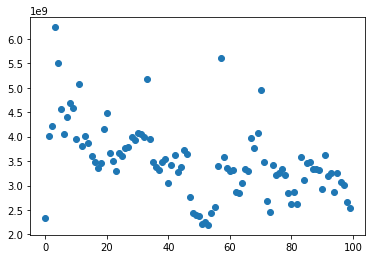

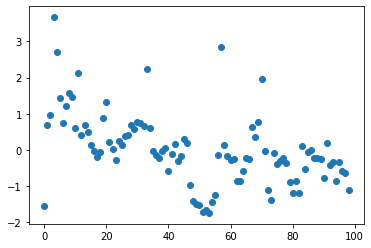

,date,Volume
488,2022-02-24,5070560000
489,2022-02-25,3941780000
490,2022-02-28,4594010000
491,2022-03-01,4679400000
492,2022-03-02,4409090000
493,2022-03-03,4062080000
494,2022-03-04,4558250000
495,2022-03-07,5506330000
496,2022-03-08,6237000000
497,2022-03-09,4220180000


In [125]:
data = df_analisys.iloc[-100:,:]['Volume'].tolist()
data.reverse()
plt.scatter(range(0,len(data)), data)
plt.show()

data = df_vols_info_01.iloc[0,:][['ss1_vols_' + str(x) for x in range(1,100) ]]
plt.scatter(range(0,len(data)), data)
plt.show()

df_analisys[['date','Volume']].iloc[-12:,]

In [126]:
# Create variable names lists to naming columns

ls_ss1vars = ['ss1_vols_' + str(x) for x in range(100,0,-1)]
len(ls_ss1vars)


100

In [127]:
#Assigns correct format to variable to apply transformations

df_vols_info_01[ls_ss1vars] = df_vols_info_01[ls_ss1vars].astype(float)
df_vols_info_01[ls_columns] = df_vols_info_01[ls_columns].astype(float)


In [128]:
df_vols_info_01 = df_vols_info_01[df_vols_info_01.notna().all(axis=1)]
df_vols_info_01 = df_vols_info_01.reset_index(drop=True)
print(df_vols_info_01.shape)

df_vols_info_01.info()



(401, 104)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Columns: 104 entries, ss1_vols_100 to date
dtypes: float64(103), object(1)
memory usage: 325.9+ KB


In [129]:
#Defines X vector to all process

X = df_vols_info_01[ls_ss1vars + ls_columns]
print(X.shape)


(401, 103)


In [130]:
# Defines the column trasformer
# This will be the standard schema : start with the pipeline for column transformers and then fit the model

#First a lil pip to treat imputation and scalation in one shot for numerical variables


pca_pip = Pipeline(steps=[('pca',PCA(n_components=3)),])


# Defines the column transformer
rf_transformer = ColumnTransformer([("passthrough", "passthrough", ls_columns),
                                     ("pca1", pca_pip, ls_ss1vars),
                                        ]) 

#Prepares pip
pip = Pipeline([('preprocessing', rf_transformer),])


#Fits the pipeline to the data
Xtr = rf_transformer.fit_transform(X)

#Saves the total procedure
#pickle.dump(kmeans_proc, open( DIRECTORY + 'kmeans_proc.pkl', 'wb'))

In [131]:
Xtr.shape

(401, 6)

In [132]:
#Defines the df of all transformations

ls_ss1pcavars = ['ss1_vols_c1','ss1_vols_c2','ss1_vols_c3']

df_vols_info_tr_01 = pd.DataFrame(Xtr,columns=ls_columns + ls_ss1pcavars)
print(df_vols_info_tr_01.shape)
df_vols_info_tr_01

(401, 6)


,last_ss_volume,mean_last3_ss_vols,pred_ss_vol,ss1_vols_c1,ss1_vols_c2,ss1_vols_c3
0,-1.566645,0.027845,0.879321,6.537801,-2.088318,-1.443662
1,0.682287,1.784379,0.966348,7.008593,-2.301575,-1.958727
2,0.982629,2.474750,0.966062,7.006576,-2.240165,-2.207057
3,3.731293,2.644586,0.969074,6.984484,-2.002547,-2.404899
4,2.998172,1.837599,0.943644,6.876202,-1.674800,-2.556960
...,...,...,...,...,...,...
396,-1.894286,-1.592739,-0.962331,-4.086935,2.136687,3.605483
397,-1.532887,-1.076798,-0.962273,-4.103855,1.695315,4.012940
398,-1.456009,-0.910817,-0.965105,-4.127940,1.321420,4.297800
399,-0.335292,-0.827779,-0.978590,-4.171351,0.746427,4.561979


In [133]:
# Concat the Datetime to the transformed data

df_vols_info_tr_01 = pd.concat([df_vols_info_01['date'],df_vols_info_tr_01],axis=1)
df_vols_info_tr_01

,date,last_ss_volume,mean_last3_ss_vols,pred_ss_vol,ss1_vols_c1,ss1_vols_c2,ss1_vols_c3
0,2022-03-11,-1.566645,0.027845,0.879321,6.537801,-2.088318,-1.443662
1,2022-03-10,0.682287,1.784379,0.966348,7.008593,-2.301575,-1.958727
2,2022-03-09,0.982629,2.474750,0.966062,7.006576,-2.240165,-2.207057
3,2022-03-08,3.731293,2.644586,0.969074,6.984484,-2.002547,-2.404899
4,2022-03-07,2.998172,1.837599,0.943644,6.876202,-1.674800,-2.556960
...,...,...,...,...,...,...,...
396,2020-08-14,-1.894286,-1.592739,-0.962331,-4.086935,2.136687,3.605483
397,2020-08-13,-1.532887,-1.076798,-0.962273,-4.103855,1.695315,4.012940
398,2020-08-12,-1.456009,-0.910817,-0.965105,-4.127940,1.321420,4.297800
399,2020-08-11,-0.335292,-0.827779,-0.978590,-4.171351,0.746427,4.561979


In [134]:
pd.concat([df_vols_info_tr_01[['date'] +ls_columns].iloc[0:1,:],
           df_vols_info_01[['date'] +ls_columns].iloc[0:1,:]],axis=0)

,date,last_ss_volume,mean_last3_ss_vols,pred_ss_vol
0,2022-03-11,-1.566645,0.027845,0.879321
0,2022-03-11,-1.566645,0.027845,0.879321


## (Volume) Additional calculations

In [135]:
#Computes Target signal

df_input = df_vols_info_tr_01.copy()
nro_rows = len(df_input)

for i in range(0,nro_rows):
#for i in range(0,3):
    
    vol_threshold = 0.2
    
    #Searches for the after indexes where the profit threshold is fullfilled 
    
    s_obs = df_input['last_ss_volume'].iloc[(i+1):]

    s_threshold = (s_obs > vol_threshold)
    idxs = s_threshold[s_threshold].index

    keepcols = ['date','last_ss_volume']
    
    try:
        target_idx = [min(idxs)]
        df_data = df_input.iloc[df_input.index==target_idx[0]]
    except:
        target_idx = []
        df_data = pd.DataFrame(columns=keepcols)

    df_data = df_data[keepcols]
    
    date = df_input['date'][i]
    
    try:
        low_movs = len(s_obs[s_obs.index<=target_idx[0]])
    except:
        low_movs = 0

    dic_rencols = {
        'date':'date2',
        'last_ss_volume': 'last_ss_volume2',
    }

    df_data = df_data.rename(columns=dic_rencols)
    df_data['date'] = date
    df_data['movs_low_vols'] = low_movs

    if i == 0:
        df_low_movs =df_data.copy()
    else:
        df_low_movs =df_low_movs.append(df_data).copy()


        
df_movs_low_vols = df_low_movs.reset_index(drop=True)
df_movs_low_vols

,date2,last_ss_volume2,date,movs_low_vols
0,2022-03-10,0.682287,2022-03-11,1
1,2022-03-09,0.982629,2022-03-10,1
2,2022-03-08,3.731293,2022-03-09,1
3,2022-03-07,2.998172,2022-03-08,1
4,2022-03-04,1.728229,2022-03-07,1
...,...,...,...,...
367,2020-09-18,1.933889,2020-09-25,5
368,2020-09-18,1.933889,2020-09-24,4
369,2020-09-18,1.933889,2020-09-23,3
370,2020-09-18,1.933889,2020-09-22,2


# Trading insights

In [136]:
for c in df_analisys.columns.tolist():
    print(c)

Date
Open
High
Low
Close
Adj Close
Volume
date
body_size
abs_body_size
upper_tail_size
lower_tail_size
body_disposal
MACD_12_26_9
MACDh_12_26_9
MACDs_12_26_9
diff_ewm50
diff_ewm200


In [187]:
# Prepares previos moements info as input variables
pd.options.mode.chained_assignment = None  # default='warn'


for i in range(0,len(df_analisys)):
#for i in range(0,1):
    
    ###############################################################################################
    nro_close_lag = 15
    
    ls_vars = [
        'date',
        'Close',
        'Volume',
        'abs_body_size',
        'upper_tail_size',
        'lower_tail_size',
        'body_disposal',
        'MACD_12_26_9',
        'MACDs_12_26_9',
        'MACDh_12_26_9',
    ]
    
    
    df_input = df_analisys[ls_vars]
    
    ls_results = []

    if i==0:
        X = df_input.iloc[-(nro_close_lag + i):,:]
        date = df_input.iloc[-1:,]['date'].iloc[0]
    else:
        X = df_input.iloc[-(nro_close_lag + i):-i,:]
        date = df_input.iloc[-(i+1):,]['date'].iloc[0]
        
    if X.loc[max(X.index)]['Volume'] == 0:
        val = X.loc[max(X.index)-1]['Volume']
        X.loc[max(X.index),'Volume'] = val

    ###############################################################################################

    
    ###############################################################################################
    #Computes slopes before the last close
    
    def weighted_preds(Xp,var,var_weight):
    
        Xp['weight1'] = 1/len(X)
        Xp['weight1'] = Xp['weight1'].cumsum()
        Xp['weight1'] = Xp['weight1']/sum(Xp['weight1'])

        Xp['weight2'] = Xp[var_weight]/sum(Xp[var_weight])

        Xp['weight'] = Xp['weight1']*Xp['weight2']
        Xp['weight'] = Xp['weight']/sum(Xp['weight'])

        y = Xp[var].values.reshape(-1, 1)
        w = Xp['weight'].values.reshape(len(Xp),)
        x = np.array([range(0,len(Xp))]).reshape(-1, 1)

        linreg = LinearRegression()

        linreg.fit(x,y,w)
        slope_close = linreg.coef_[0][0]
        yhat = linreg.predict(x)

        Xp['yhat'] = yhat
        Xp['yhat_sup'] = yhat + yhat.std()
        Xp['yhat_inf'] = yhat - yhat.std()
        Xp['slope'] = math.atan(slope_close)*(180/math.pi)

        Xo = Xp[['yhat','yhat_sup','yhat_inf','slope']]

        return Xo

    Xp = X[['Close','Volume']]
    Xout = weighted_preds(Xp,'Close','Volume')
    
    Xout = Xout.rename(columns={'yhat':'pred_close_long',
                                'yhat_sup':'pred_close_long_upper',
                                'yhat_inf':'pred_close_long_lower',
                                'slope':'slope_close_long'})

    Xout = pd.concat([Xp,Xout],axis=1)


    Xp = X.iloc[-8:]
    Xout2 = weighted_preds(Xp,'Close','Volume')
    Xout2 = Xout2[['yhat','slope']].rename(columns={'yhat':'pred_close_short',
                                                    'slope':'slope_close_short'})

    Xout = pd.concat([Xout,Xout2],axis=1)
    Xout['slope_close_prom'] = (Xout['slope_close_long'] + Xout['slope_close_short'])/2



    actual_close = X['Close'].values[-1]
    pred_close_long = Xout['pred_close_long'].values[-1]
    pred_close_long_upper = Xout['pred_close_long_upper'].values[-1]
    pred_close_long_lower = Xout['pred_close_long_lower'].values[-1]
    
    slope_close_long = Xout['slope_close_long'].values[-1]
    slope_close_short = Xout['slope_close_short'].values[-1]
    
    diff_closewpred_close =  actual_close - pred_close_long
    pp_close_interval_distance = abs(diff_closewpred_close)/abs(pred_close_long_upper-pred_close_long)
    
    ls_results.append(slope_close_long)
    ls_results.append(slope_close_short)
    ls_results.append(diff_closewpred_close)
    ls_results.append(pp_close_interval_distance)
    
    ls_columns = [
        'slope_close_long',
        'slope_close_short',
        'diff_closewpred_close',
        'pp_close_interval_distance',
    ]
    ###############################################################################################
    
    
    
    ###############################################################################################
    df_macd_l4 = X[['MACD_12_26_9','MACDs_12_26_9','MACDh_12_26_9','Volume']].iloc[-3:,]

    df_macd_l4['neg'] = 0
    df_macd_l4.loc[df_macd_l4['MACDh_12_26_9']<0,'neg'] = 1

    df_macd_l4['pos'] = 0
    df_macd_l4.loc[df_macd_l4['MACDh_12_26_9']>=0,'pos'] = 1

    recent_macd_cross = 0
    if max(df_macd_l4['neg']) + max(df_macd_l4['pos']) == 2:
        recent_macd_cross = 1
        
    mean_last_macd = df_macd_l4['MACD_12_26_9'].mean()
    mean_last_macdh = df_macd_l4['MACDh_12_26_9'].mean()

        
    Xp = df_macd_l4
    
    try:
        Xout = weighted_preds(Xp,'MACD_12_26_9','Volume')
        slope = Xout['slope'].values
        slope_macd = slope[-1]
    except:
        slope = None
        slope_macd = None
        
    try:
        Xout = weighted_preds(Xp,'MACDs_12_26_9','Volume')
        slope = Xout['slope'].values
        slope_macds = slope[-1]
    except:
        slope = None
        slope_macds = None
    
    
    ls_results.append(recent_macd_cross)
    ls_results.append(slope_macd)
    ls_results.append(slope_macds)
    ls_results.append(mean_last_macd)
    ls_results.append(mean_last_macdh)
    
    ls_columns = ls_columns + [
        'recent_macd_cross',
        'slope_macd',
        'slope_macds',
        'mean_last_macd',
        'mean_last_macdh',
    ]
    ###############################################################################################
    
    

    ###############################################################################################
    #Computes pp for the associated volumes
    X['pp_vol'] = X['Volume'] / sum(X['Volume'])
    pp_vol_last2 = sum(X['pp_vol'].iloc[-2:])
    ls_results.append(pp_vol_last2)
    
    ls_columns = ls_columns + [
        'pp_vol_last2']
    ###############################################################################################
    
    
    
    ###############################################################################################
    # Joins the ss closes df with the slopes df
    df_results = pd.DataFrame(np.array([ls_results]),columns=ls_columns)
    df_results
    
    df_info = pd.concat([df_results],axis=1,sort=False)
    df_info['date'] = date
    
    if i == 0:
        df_info_01 = df_info.copy()
    else:
        df_info_01 = df_info_01.append(df_info,sort=False).copy()
    ###############################################################################################
        
df_info_01 = df_info_01.reset_index(drop=True)
df_info_01

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in double_scalars


,slope_close_long,slope_close_short,diff_closewpred_close,pp_close_interval_distance,recent_macd_cross,slope_macd,slope_macds,mean_last_macd,mean_last_macdh,pp_vol_last2,date
0,-85.226815,-85.999845,-12.754432,0.246502,0.0,-45.577198,-52.171998,-66.782598,-5.607827,0.097171,2022-03-11
1,-84.679975,-86.545294,25.111127,0.541221,0.0,59.308104,-53.567289,-67.028316,-7.255501,0.123599,2022-03-10
2,-85.168944,-87.825964,40.578749,0.793808,0.0,-66.315478,-64.322401,-65.226285,-7.267345,0.158328,2022-03-09
3,-85.874464,-88.470254,-65.044918,1.085899,1.0,-83.656621,-64.491054,-59.994407,-3.852304,0.180139,2022-03-08
4,-83.098902,-87.42547,-84.571699,2.369161,1.0,-79.675916,-19.740521,-54.174561,1.004466,0.161241,2022-03-07
...,...,...,...,...,...,...,...,...,...,...,...
495,88.858786,88.858786,14.088648,0.198452,0,None,None,NaN,NaN,0.393596,2020-03-25
496,88.374225,88.374225,59.190247,1.502621,0,None,None,NaN,NaN,0.468037,2020-03-24
497,-89.302891,-89.302891,4.244761,0.063255,0,None,None,NaN,NaN,0.674229,2020-03-23
498,-89.451574,-89.451574,0.0,0.0,0,None,None,NaN,NaN,1.0,2020-03-20


In [188]:
df_insights_info_tr_01 = df_info_01.copy()
print(df_insights_info_tr_01.shape)

(500, 11)


In [189]:
df_slopes_long = df_insights_info_tr_01[['date','slope_close_long']]

slope_close_long_m1 = df_insights_info_tr_01['slope_close_long'].shift(-1)
slope_close_long_m2 = df_insights_info_tr_01['slope_close_long'].shift(-2)

df_insights_info_tr_01['slope_close_long_changerate_m0'] = df_slopes_long['slope_close_long'] -slope_close_long_m1
df_insights_info_tr_01['slope_close_long_changerate_m1'] = slope_close_long_m1 - slope_close_long_m2
df_insights_info_tr_01['slope_close_long_changerate_diff'] = df_insights_info_tr_01['slope_close_long_changerate_m0'] - df_insights_info_tr_01['slope_close_long_changerate_m1']

df_insights_info_tr_01[['date',
                        'slope_close_long',
                        'slope_close_long_changerate_m0',
                        'slope_close_long_changerate_m1',
                        'slope_close_long_changerate_diff']]

,date,slope_close_long,slope_close_long_changerate_m0,slope_close_long_changerate_m1,slope_close_long_changerate_diff
0,2022-03-11,-85.226815,-0.546841,0.48897,-1.03581
1,2022-03-10,-84.679975,0.48897,0.705519,-0.216549
2,2022-03-09,-85.168944,0.705519,-2.775562,3.481081
3,2022-03-08,-85.874464,-2.775562,-18.532636,15.757074
4,2022-03-07,-83.098902,-18.532636,9.300256,-27.832892
...,...,...,...,...,...
495,2020-03-25,88.858786,0.48456,177.677117,-177.192557
496,2020-03-24,88.374225,177.677117,0.148683,177.528434
497,2020-03-23,-89.302891,0.148683,-89.451574,89.600257
498,2020-03-20,-89.451574,-89.451574,NaN,NaN


In [190]:

def weighted_preds(Xp,var,var_weight):
    
    Xp['weight1'] = 1/len(X)
    Xp['weight1'] = Xp['weight1'].cumsum()
    Xp['weight1'] = Xp['weight1']/sum(Xp['weight1'])

    Xp['weight2'] = Xp[var_weight]/sum(Xp[var_weight])

    Xp['weight'] = Xp['weight1']*Xp['weight2']
    Xp['weight'] = Xp['weight']/sum(Xp['weight'])

    y = Xp[var].values.reshape(-1, 1)
    w = Xp['weight'].values.reshape(len(Xp),)
    x = np.array([range(0,len(Xp))]).reshape(-1, 1)

    linreg = LinearRegression()

    linreg.fit(x,y,w)
    slope_close = linreg.coef_[0][0]
    yhat = linreg.predict(x)

    Xp['yhat'] = yhat
    Xp['yhat_sup'] = yhat + yhat.std()
    Xp['yhat_inf'] = yhat - yhat.std()
    Xp['slope'] = math.atan(slope_close)*(180/math.pi)

    Xo = Xp[['yhat','yhat_sup','yhat_inf','slope']]

    return Xo

i=0

if i==0:
    Xp = df_analisys[['Close','Volume']].iloc[-(9 + i):]
    date = df_analisys[['date']].iloc[-(28 + i):]
else:
    Xp = df_analisys[['Close','Volume']].iloc[-(28 + i):-i]
    date = df_analisys[['date']].iloc[-(28 + i):-i]

Xout = weighted_preds(Xp,'Close','Volume')
Xout = Xout.rename(columns={'yhat':'pred_close_long',
                            'yhat_sup':'pred_close_long_sup',
                            'yhat_inf':'pred_close_long_inf',
                            'slope':'slope_close_long'})


Xout = pd.concat([Xp,Xout],axis=1)

if i==0:
    Xp = df_analisys[['Close','Volume']].iloc[-(8+i):]
else:
    Xp = df_analisys[['Close','Volume']].iloc[-(8+i):-i]
    
Xout2 = weighted_preds(Xp,'Close','Volume')
Xout2 = Xout2[['yhat','slope']].rename(columns={'yhat':'pred_close_short','slope':'slope_close_short'})

Xout = pd.concat([Xout,Xout2],axis=1)
Xout['slope_close_prom'] = (Xout['slope_close_long'] + Xout['slope_close_short'])/2

#Xout

2022-02-01
2022-03-11


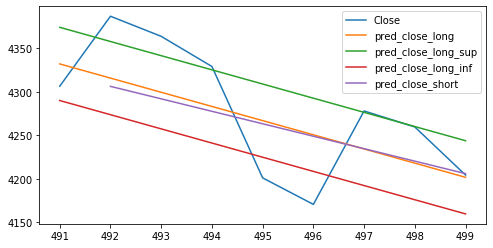

In [191]:
df_obs = Xout[['Close','pred_close_long','pred_close_long_sup','pred_close_long_inf','pred_close_short']]

print(min(date['date']))
print(max(date['date']))
df_obs.plot(figsize=(8,4))

In [192]:
df_insights_info_tr_01.iloc[9:21,:][[
    'date',
    'slope_close_long',
    'slope_close_long_changerate_m0',
    'slope_close_long_changerate_m1',
    'slope_close_short',
    'diff_closewpred_close',
    'pp_close_interval_distance',
    'slope_macd',
    'mean_last_macd',
    'mean_last_macdh',
    'recent_macd_cross',
]]

,date,slope_close_long,slope_close_long_changerate_m0,slope_close_long_changerate_m1,slope_close_short,diff_closewpred_close,pp_close_interval_distance,slope_macd,mean_last_macd,mean_last_macdh,recent_macd_cross
9,2022-02-28,-85.996431,1.015519,0.576333,79.554903,69.203898,1.121062,78.439494,-64.551805,-10.438386,0.0
10,2022-02-25,-87.01195,0.576333,0.00446,-85.110099,97.607848,1.179263,65.251919,-66.70222,-15.198398,0.0
11,2022-02-24,-87.588283,0.00446,-0.694593,-88.209436,16.914945,0.164891,-81.652256,-63.438757,-15.734534,0.0
12,2022-02-23,-87.592743,-0.694593,-0.828394,-88.484722,-65.003099,0.632494,-84.471204,-55.639222,-11.868633,0.0
13,2022-02-22,-86.89815,-0.828394,-1.492412,-87.782754,-40.836212,0.512194,-82.203243,-46.917013,-6.113582,0.0
14,2022-02-18,-86.069756,-1.492412,-4.697637,-87.332848,-37.417719,0.595008,-80.492094,-40.354325,-1.07929,1.0
15,2022-02-17,-84.577344,-4.697637,-4.3098,-86.704388,-42.415876,0.931931,-67.651051,-37.169159,1.836054,1.0
16,2022-02-16,-79.879707,-4.3098,-22.21387,-84.726564,16.53427,0.68308,64.165167,-36.710471,2.753756,0.0
17,2022-02-15,-75.569907,-22.21387,-131.388126,-86.62102,4.672697,0.278292,-48.761867,-36.317695,3.83497,0.0
18,2022-02-14,-53.356036,-131.388126,-7.056404,-87.16639,-75.886003,13.065246,-79.377334,-33.374962,7.736446,0.0


In [193]:
df_obs = df_insights_info_tr_01[df_insights_info_tr_01.notna().all(axis=1)==False]

df_obs

,slope_close_long,slope_close_short,diff_closewpred_close,pp_close_interval_distance,recent_macd_cross,slope_macd,slope_macds,mean_last_macd,mean_last_macdh,pp_vol_last2,date,slope_close_long_changerate_m0,slope_close_long_changerate_m1,slope_close_long_changerate_diff
465,74.828342,-77.803625,0.46216,0.029006,0,-78.741573,None,95.668513,-20.68605,0.12392,2020-05-07,-1.360653,-4.569229,3.208576
466,76.188994,-83.900197,-29.816667,1.696507,0,-80.811504,None,100.943877,-21.291171,0.123463,2020-05-06,-4.569229,-1.116373,-3.452856
467,80.758223,-81.112763,-18.438248,0.694398,0,-80.813696,None,107.513854,NaN,0.121237,2020-05-05,-1.116373,-1.834051,0.717678
468,81.874596,-68.963452,-44.541338,1.471897,0,-83.23442,None,114.93676,NaN,0.11598,2020-05-04,-1.834051,-1.279577,-0.554474
469,83.708647,82.933878,-64.167413,1.637393,0,-80.829672,None,121.246286,NaN,0.137085,2020-05-01,-1.279577,0.625987,-1.905565
470,84.988224,87.598517,8.294023,0.168349,0,-16.630195,None,124.251638,NaN,0.15393,2020-04-30,0.625987,2.821364,-2.195376
471,84.362236,87.82669,52.780088,1.20594,0,10.495869,None,125.171127,NaN,0.145106,2020-04-29,2.821364,-0.375686,3.19705
472,81.540872,85.842184,11.670597,0.40173,0,-64.758293,None,125.676298,NaN,0.127641,2020-04-28,-0.375686,-0.384063,0.008377
473,81.916559,84.310336,35.083726,1.153296,0,None,None,126.819296,NaN,0.123097,2020-04-27,-0.384063,-1.901025,1.516962
474,82.300621,45.346649,6.411035,0.20061,0,None,None,127.124511,NaN,0.128311,2020-04-24,-1.901025,-1.959083,0.058058


In [194]:
#df.index[np.isinf(df).any(1)]

df_insights_info_tr_01 = df_insights_info_tr_01[df_insights_info_tr_01.notna().all(axis=1)]
df_insights_info_tr_01 = df_insights_info_tr_01.reset_index(drop=True)
print(df_insights_info_tr_01.shape)

df_insights_info_tr_01.info()

(465, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   slope_close_long                  465 non-null    object
 1   slope_close_short                 465 non-null    object
 2   diff_closewpred_close             465 non-null    object
 3   pp_close_interval_distance        465 non-null    object
 4   recent_macd_cross                 465 non-null    object
 5   slope_macd                        465 non-null    object
 6   slope_macds                       465 non-null    object
 7   mean_last_macd                    465 non-null    object
 8   mean_last_macdh                   465 non-null    object
 9   pp_vol_last2                      465 non-null    object
 10  date                              465 non-null    object
 11  slope_close_long_changerate_m0    465 non-null    object
 12  slope_close_

# Target signal

In [195]:
df_analisys = df_analisys.sort_values(['date'])
df_analisys = df_analisys.reset_index(drop=True)
print(df_analisys.shape)

(500, 18)


In [196]:
#Computes Target signal

nro_rows = len(df_analisys)
for i in range(0,nro_rows):
    
    nro_steps = 6
    
    try:
        #Searches for the after indexes where the profit threshold is fullfilled 
        
        date = df_analisys['date'][i]
        target_date = df_analisys['date'][i+nro_steps]
        
        target_close = df_analisys['Close'].iloc[i+nro_steps]
        target_profit =  target_close - df_analisys['Close'][i]


        
        
        ls_results = [date,target_date,target_close,target_profit]
        df_results = pd.DataFrame(np.array([ls_results]),columns=['date','target_date','target_close','target_profit'])
        
        
        if i == 0:
            df_target =df_results.copy()
        else:
            df_target =df_target.append(df_results).copy()
            
    except:
        pass
        
df_target = df_target.reset_index(drop=True)
df_target

,date,target_date,target_close,target_profit
0,2020-03-19,2020-03-27,2541.469971,132.080078
1,2020-03-20,2020-03-30,2626.649902,321.72998
2,2020-03-23,2020-03-31,2584.590088,347.190186
3,2020-03-24,2020-04-01,2470.5,23.169922
4,2020-03-25,2020-04-02,2526.899902,51.339844
...,...,...,...,...
489,2022-02-25,2022-03-07,4201.089844,-183.560059
490,2022-02-28,2022-03-08,4170.700195,-203.239746
491,2022-03-01,2022-03-09,4277.879883,-28.379883
492,2022-03-02,2022-03-10,4259.52002,-127.02002


In [197]:
df_analisys_01 = pd.merge(df_analisys,
                         df_target,
                         on = ['date'],
                         how = 'left').copy()

print(df_analisys.shape)
print(df_analisys_01.shape)

print(df_analisys_01['target_profit'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))

df_analisys_01

(500, 18)
(500, 21)
          index  target_profit
129 -328.410156              1
127 -306.399902              1
128 -248.899902              1
287 -239.870117              1
130 -230.339844              1
..          ...            ...
331  319.320068              1
371  321.729980              1
338  347.190186              1
329  357.410156              1
0           NaN              6

[493 rows x 2 columns]


,Date,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,...,lower_tail_size,body_disposal,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,diff_ewm50,diff_ewm200,target_date,target_close,target_profit
0,2020-03-19,2393.479980,2466.969971,2319.780029,2409.389893,2409.389893,7946710000,2020-03-19,15.909912,15.909912,...,73.699951,1,NaN,NaN,NaN,NaN,NaN,2020-03-27,2541.469971,132.080078
1,2020-03-20,2431.939941,2453.010010,2295.560059,2304.919922,2304.919922,9044690000,2020-03-20,-127.020020,127.020020,...,9.359863,0,NaN,NaN,NaN,NaN,NaN,2020-03-30,2626.649902,321.72998
2,2020-03-23,2290.709961,2300.729980,2191.860107,2237.399902,2237.399902,7402180000,2020-03-23,-53.310059,53.310059,...,45.539795,0,NaN,NaN,NaN,NaN,NaN,2020-03-31,2584.590088,347.190186
3,2020-03-24,2344.439941,2449.709961,2344.439941,2447.330078,2447.330078,7547350000,2020-03-24,102.890137,102.890137,...,0.000000,1,NaN,NaN,NaN,NaN,NaN,2020-04-01,2470.5,23.169922
4,2020-03-25,2457.770020,2571.419922,2407.530029,2475.560059,2475.560059,8285670000,2020-03-25,17.790039,17.790039,...,50.239990,1,NaN,NaN,NaN,NaN,NaN,2020-04-02,2526.899902,51.339844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2022-03-07,4327.009766,4327.009766,4199.850098,4201.089844,4201.089844,5506330000,2022-03-07,-125.919922,125.919922,...,1.239746,0,-60.074739,-4.452191,-55.622548,-263.381165,-195.633204,NaN,NaN,NaN
496,2022-03-08,4202.660156,4276.939941,4157.870117,4170.700195,4170.700195,6237000000,2022-03-08,-31.959961,31.959961,...,12.830078,0,-68.981119,-10.686857,-58.294262,-282.250389,-223.773869,NaN,NaN,NaN
497,2022-03-09,4223.100098,4299.399902,4223.100098,4277.879883,4277.879883,4220180000,2022-03-09,54.779785,54.779785,...,0.000000,1,-66.622996,-6.662987,-59.960009,-168.205184,-115.434040,NaN,NaN,NaN
498,2022-03-10,4252.549805,4268.279785,4209.799805,4259.520020,4259.520020,4008690000,2022-03-10,6.970215,6.970215,...,42.750000,1,-65.480832,-4.416658,-61.064173,-179.248771,-132.462621,NaN,NaN,NaN


In [198]:
df_analisys_01[['Close','target_close','target_profit']]

,Close,target_close,target_profit
0,2409.389893,2541.469971,132.080078
1,2304.919922,2626.649902,321.72998
2,2237.399902,2584.590088,347.190186
3,2447.330078,2470.5,23.169922
4,2475.560059,2526.899902,51.339844
...,...,...,...
495,4201.089844,NaN,NaN
496,4170.700195,NaN,NaN
497,4277.879883,NaN,NaN
498,4259.520020,NaN,NaN


In [199]:
df_varbins = df_analisys_01[['target_profit']]
df_varbins['target_bins'] = pd.qcut(df_varbins['target_profit'], 20, duplicates='drop')
df_varbins['target_bins'] = df_varbins['target_bins'].cat.codes.apply(lambda x: "{:02d}".format(x+1)) + '-' + df_varbins['target_bins'].astype(str)

print(df_varbins['target_bins'].value_counts(dropna=False).reset_index().sort_values(['index']))

                      index  target_bins
20                   00-nan            6
4   01-(-328.411, -142.323]           25
3    02-(-142.323, -96.674]           25
14    03-(-96.674, -65.594]           24
7     04-(-65.594, -45.312]           25
6     05-(-45.312, -27.423]           25
18    06-(-27.423, -10.598]           24
11      07-(-10.598, 1.009]           25
10         08-(1.009, 8.62]           25
17        09-(8.62, 16.837]           24
1       10-(16.837, 25.025]           25
5       11-(25.025, 35.688]           25
15      12-(35.688, 45.502]           24
2       13-(45.502, 54.491]           25
8       14-(54.491, 67.019]           25
16        15-(67.019, 78.4]           24
13        16-(78.4, 91.908]           25
12     17-(91.908, 104.917]           25
19    18-(104.917, 127.357]           24
0     19-(127.357, 156.795]           25
9      20-(156.795, 357.41]           25


In [200]:
mean_time = abs(df_varbins['target_profit']).mean()
print('Mean profit: ', mean_time)

Mean profit:  72.84089147899797


In [201]:
#Computes the target difference in transcurred time
df_analisys_01['target_date_diff'] =  df_analisys_01['target_date'] - df_analisys_01['date']
df_analisys_01['target_date_diff'] = df_analisys_01['target_date_diff'] / np.timedelta64(1,'m')

df_analisys_01

,Date,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,...,body_disposal,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,diff_ewm50,diff_ewm200,target_date,target_close,target_profit,target_date_diff
0,2020-03-19,2393.479980,2466.969971,2319.780029,2409.389893,2409.389893,7946710000,2020-03-19,15.909912,15.909912,...,1,NaN,NaN,NaN,NaN,NaN,2020-03-27,2541.469971,132.080078,11520.0
1,2020-03-20,2431.939941,2453.010010,2295.560059,2304.919922,2304.919922,9044690000,2020-03-20,-127.020020,127.020020,...,0,NaN,NaN,NaN,NaN,NaN,2020-03-30,2626.649902,321.72998,14400.0
2,2020-03-23,2290.709961,2300.729980,2191.860107,2237.399902,2237.399902,7402180000,2020-03-23,-53.310059,53.310059,...,0,NaN,NaN,NaN,NaN,NaN,2020-03-31,2584.590088,347.190186,11520.0
3,2020-03-24,2344.439941,2449.709961,2344.439941,2447.330078,2447.330078,7547350000,2020-03-24,102.890137,102.890137,...,1,NaN,NaN,NaN,NaN,NaN,2020-04-01,2470.5,23.169922,11520.0
4,2020-03-25,2457.770020,2571.419922,2407.530029,2475.560059,2475.560059,8285670000,2020-03-25,17.790039,17.790039,...,1,NaN,NaN,NaN,NaN,NaN,2020-04-02,2526.899902,51.339844,11520.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2022-03-07,4327.009766,4327.009766,4199.850098,4201.089844,4201.089844,5506330000,2022-03-07,-125.919922,125.919922,...,0,-60.074739,-4.452191,-55.622548,-263.381165,-195.633204,NaN,NaN,NaN,NaN
496,2022-03-08,4202.660156,4276.939941,4157.870117,4170.700195,4170.700195,6237000000,2022-03-08,-31.959961,31.959961,...,0,-68.981119,-10.686857,-58.294262,-282.250389,-223.773869,NaN,NaN,NaN,NaN
497,2022-03-09,4223.100098,4299.399902,4223.100098,4277.879883,4277.879883,4220180000,2022-03-09,54.779785,54.779785,...,1,-66.622996,-6.662987,-59.960009,-168.205184,-115.434040,NaN,NaN,NaN,NaN
498,2022-03-10,4252.549805,4268.279785,4209.799805,4259.520020,4259.520020,4008690000,2022-03-10,6.970215,6.970215,...,1,-65.480832,-4.416658,-61.064173,-179.248771,-132.462621,NaN,NaN,NaN,NaN


In [202]:
df_varbins = df_analisys_01[['target_date_diff']]
df_varbins['target_date_bins'] = pd.qcut(df_varbins['target_date_diff'], 20, duplicates='drop')
df_varbins['target_date_bins'] = df_varbins['target_date_bins'].cat.codes.apply(lambda x: "{:02d}".format(x+1)) + '-' + df_varbins['target_date_bins'].astype(str)

print(df_varbins['target_date_bins'].value_counts(dropna=False).reset_index().sort_values(['index']))

                     index  target_date_bins
3                   00-nan                 6
0  01-(11519.999, 12960.0]               375
1    02-(12960.0, 14400.0]                71
2    03-(14400.0, 15840.0]                46
4    04-(15840.0, 17280.0]                 2


In [203]:
# Computes high time to produce additional categories fo the target

df_varbins = df_varbins.sort_values(['target_date_diff'])
df_varbins = df_varbins[df_varbins.notna().all(axis=1)]
size = round(len(df_varbins)*(0.5))

high_time = df_varbins.iloc[size,:]['target_date_diff']
high_time

11520.0

In [204]:
mean_time = df_varbins['target_date_diff'].mode()
print('Mean awaiting time to profit: ', mean_time)

Mean awaiting time to profit:  0    11520.0
dtype: float64


In [205]:
#computes the target order movement
df_analisys_01['target_order'] = 'NULL'

df_analisys_01.loc[df_analisys_01['target_profit'] < 0, 'target_order'] = 'SELL'

df_analisys_01.loc[(df_analisys_01['target_profit'] < 0)
                   &(df_analisys_01['target_date_diff'] > high_time), 'target_order'] = 'SELL2'


df_analisys_01.loc[df_analisys_01['target_profit'] > 0, 'target_order'] = 'BUY'

df_analisys_01.loc[(df_analisys_01['target_profit'] > 0)
                   &(df_analisys_01['target_date_diff'] > high_time), 'target_order'] = 'BUY2'

df_analisys_01['target_order_bin'] = 0
df_analisys_01.loc[df_analisys_01['target_order'].isin(['BUY','BUY2']), 'target_order_bin'] = 1

print(df_analisys_01['target_order'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))
print(df_analisys_01['target_order_bin'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))


   index  target_order
0    BUY           210
1   BUY2           115
4   NULL             6
2   SELL           113
3  SELL2            56
   index  target_order_bin
1      0               175
0      1               325


# Attaches target variable to the df with transformations

In [206]:
ls_tgcols = [
    'date',
    'Close',
    'Volume',
    'target_order',
    'target_order_bin',
    'target_close',
    'target_profit',
    'target_date',
    'target_date_diff',
]




df_transformations_100 = pd.merge(df_vols_info_tr_01,
                           df_insights_info_tr_01,
                           on = ['date'],
                           how='inner'
                         ).copy()


df_analisys_100 = pd.merge(df_transformations_100,
                           df_analisys_01[ls_tgcols],
                           on = ['date'],
                           how='inner'
                         ).copy()


df_analisys_100 = df_analisys_100.sort_values(['date']).reset_index(drop=True)

print(df_analisys_100.shape)

df_analisys_100


(401, 28)


,date,last_ss_volume,mean_last3_ss_vols,pred_ss_vol,ss1_vols_c1,ss1_vols_c2,ss1_vols_c3,slope_close_long,slope_close_short,diff_closewpred_close,...,slope_close_long_changerate_m1,slope_close_long_changerate_diff,Close,Volume,target_order,target_order_bin,target_close,target_profit,target_date,target_date_diff
0,2020-08-10,-0.987783,-1.060727,-1.009918,-4.314491,0.429101,4.715359,85.357964,86.15337,1.248621,...,0.776858,-0.278984,3360.469971,4318570000,BUY,1,3389.780029,29.310059,2020-08-18,11520.0
1,2020-08-11,-0.335292,-0.827779,-0.978590,-4.171351,0.746427,4.561979,84.913602,82.33228,-26.637603,...,0.497874,-0.942236,3333.689941,5087650000,BUY,1,3374.850098,41.160156,2020-08-19,11520.0
2,2020-08-12,-1.456009,-0.910817,-0.965105,-4.127940,1.321420,4.297800,85.226602,82.947582,4.81665,...,-0.444362,0.757362,3380.350098,3768560000,BUY,1,3385.51001,5.159912,2020-08-20,11520.0
3,2020-08-13,-1.532887,-1.076798,-0.962273,-4.103855,1.695315,4.012940,85.019828,82.030526,-10.120206,...,0.313,-0.519774,3373.429932,3648810000,BUY,1,3397.159912,23.72998,2020-08-21,11520.0
4,2020-08-14,-1.894286,-1.592739,-0.962331,-4.086935,2.136687,3.605483,84.546987,80.251539,-15.289478,...,-0.206774,-0.266067,3372.850098,3193400000,BUY2,1,3431.280029,58.429932,2020-08-24,14400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,2022-03-07,2.998172,1.837599,0.943644,6.876202,-1.674800,-2.556960,-83.098902,-87.42547,-84.571699,...,9.300256,-27.832892,4201.089844,5506330000,NULL,0,NaN,NaN,NaN,NaN
397,2022-03-08,3.731293,2.644586,0.969074,6.984484,-2.002547,-2.404899,-85.874464,-88.470254,-65.044918,...,-18.532636,15.757074,4170.700195,6237000000,NULL,0,NaN,NaN,NaN,NaN
398,2022-03-09,0.982629,2.474750,0.966062,7.006576,-2.240165,-2.207057,-85.168944,-87.825964,40.578749,...,-2.775562,3.481081,4277.879883,4220180000,NULL,0,NaN,NaN,NaN,NaN
399,2022-03-10,0.682287,1.784379,0.966348,7.008593,-2.301575,-1.958727,-84.679975,-86.545294,25.111127,...,0.705519,-0.216549,4259.520020,4008690000,NULL,0,NaN,NaN,NaN,NaN


In [207]:
print(df_analisys_100.shape)
print(min(df_analisys_100['date']))
print(max(df_analisys_100['date']))

(401, 28)
2020-08-10
2022-03-11


In [208]:
print(df_analisys_100['target_order'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))


   index  target_order
0    BUY           165
2   BUY2            84
4   NULL             6
1   SELL            92
3  SELL2            54


In [209]:
# SAVING POINT

DIR_OUTPUTS = r'C:\Users\willi\Documents\EJERCICIOS\TRADING\outputs/'

df_analisys_100.to_pickle(DIR_OUTPUTS + 'df_spx500_1d_s1' + '.pkl')
print(df_analisys_100.shape)
print(dt.datetime.now())

(401, 28)
2022-03-11 20:06:46.820148


In [210]:
df_obs = df_analisys_01[
    (df_analisys_01['date']<=dt.datetime(2022,2,1).date())
    &(df_analisys_01['date']>=dt.datetime(2022,1,20).date())
][['date','MACDh_12_26_9','MACD_12_26_9','MACDs_12_26_9']]

df_obs

,date,MACDh_12_26_9,MACD_12_26_9,MACDs_12_26_9
464,2022-01-20,-29.372366,-29.733817,-0.361451
465,2022-01-21,-36.688846,-46.222508,-9.533662
466,2022-01-24,-38.486534,-57.641830,-19.155296
467,2022-01-25,-40.846839,-70.213845,-29.367006
468,2022-01-26,-40.333333,-79.783672,-39.450339
469,2022-01-27,-39.032112,-88.240479,-49.208367
470,2022-01-28,-28.999207,-85.457375,-56.458168
471,2022-01-31,-15.334352,-75.626108,-60.291756
472,2022-02-01,-3.438241,-64.589557,-61.151317


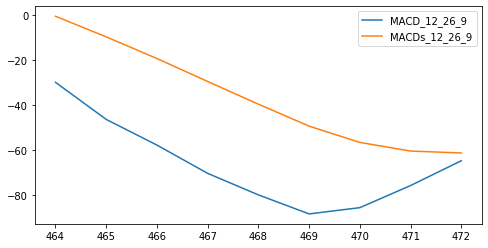

In [211]:
df_obs[['MACD_12_26_9','MACDs_12_26_9']].plot(figsize=(8,4))